# 🖌️ View as RGB images


In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq
import lovely_tensors as lt

In [ ]:
# |hide
lt.monkey_patch()

In [ ]:
# |export
# |hide

from typing import Any, Optional as O

from matplotlib import axes, figure
from PIL import Image
import torch

from lovely_numpy.utils.utils import cached_property
from lovely_numpy.utils.pad import pad_frame_gutters
from lovely_numpy.utils.tile2d import hypertile
from lovely_numpy.repr_rgb import fig_rgb
from lovely_numpy import config as np_config

from lovely_tensors.utils.misc import to_numpy
from lovely_tensors.utils.config import get_config


In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.

class RGBProxy():
    """Flexible `PIL.Image.Image` wrapper"""

    def __init__(self, t:torch.Tensor):
        assert t.ndim >= 3, f"Expecting at least 3 dimensions, got shape{t.shape}={t.dim()}"
        self.t =t
        self.params = dict(denorm   = None,
                            cl         = False,
                            gutter_px  = 3,
                            frame_px   = 1,
                            scale      = 1,
                            view_width = 966,
                            ax = None)


    def __call__(self,
                denorm      :Any    =None,
                cl          :Any    =False,
                gutter_px   :O[int] =None,
                frame_px    :O[int] =None,
                scale       :O[int] =None,
                view_width  :O[int] =None,
                ax          :O[axes.Axes]=None):

        self.params.update( { k:v for
                            k,v in locals().items()
                            if k != "self" and v is not None } )
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        cfg = get_config()
        with np_config(fig_close=cfg.fig_close, fig_show=cfg.fig_show):
            return fig_rgb(to_numpy(self.t), **self.params)

    def _repr_png_(self):
        from IPython.core.pylabtools import print_figure
        return print_figure(self.fig, fmt="png", pad_inches=0,
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})


In [ ]:
# |export
def rgb(x           :torch.Tensor,  # Tensor to display. [[...], C,H,W] or [[...], H,W,C]
        denorm      :Any =None,     # Reverse per-channel normalizatoin
        cl          :Any =False,    # Channel-last
        gutter_px   :int =3,        # If more than one tensor -> tile with this gutter width
        frame_px    :int =1,        # If more than one tensor -> tile with this frame width
        scale       :int =1,        # Scale up. Can't scale down.
        view_width  :int =966,      # target width of the image
        ax          :O[axes.Axes] =None # Use this Axes
        ) -> RGBProxy:

    args = locals()
    del args["x"]

    return RGBProxy(x)(**args)

In [ ]:
# |hide
image = torch.load("mysteryman.pt")

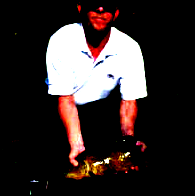

In [ ]:
rgb(image)

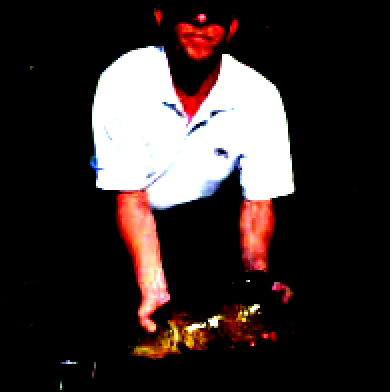

In [ ]:
rgb(image, scale=2)

In [ ]:
two_images = torch.stack([image]*2)
two_images

tensor[2, 3, 196, 196] n=230496 (0.9Mb) x∈[-2.118, 2.640] μ=-0.388 σ=1.073

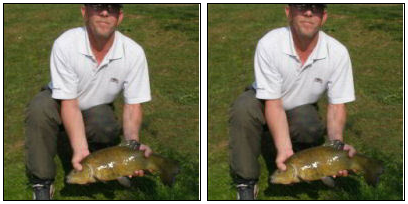

In [ ]:
in_stats = (    (0.485, 0.456, 0.406),  # Mean
                (0.229, 0.224, 0.225) ) # std
rgb(two_images, denorm=in_stats)

In [ ]:
# Make 8 images with progressively higher brightness and stack them 2x2x2.
eight_images = (torch.stack([image]*8) + torch.linspace(-2, 2, 8)[:,None,None,None])
eight_images = (eight_images
                    .mul(torch.tensor(in_stats[1])[:,None,None])
                    .add(torch.tensor(in_stats[0])[:,None,None])
                    .clamp(0,1)
                    .view(2,2,2,3,196,196)
)
eight_images

tensor[2, 2, 2, 3, 196, 196] n=921984 (3.5Mb) x∈[0., 1.000] μ=0.382 σ=0.319

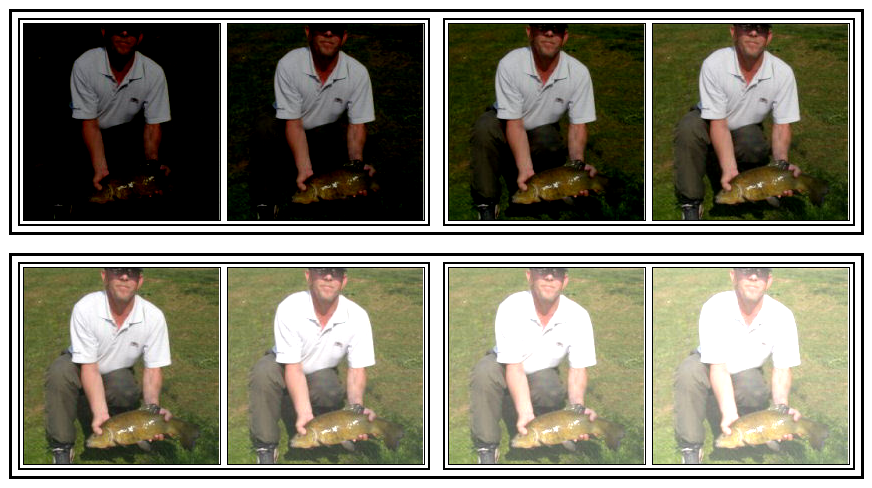

In [ ]:
rgb(eight_images)

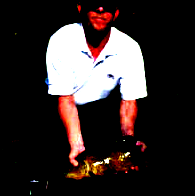

In [ ]:
# You can do channel-last too:
rgb(image.permute(1, 2, 0), cl=True)

In [ ]:
#|hide

try:
    rgb(torch.tensor([]).view((3,0,0))).fig
except AssertionError as e:
    test_eq(e.args[0], "Expecting non-empty input, got shape=((3, 0, 0))")
else:
    raise AssertionError("Expected AssertionError, but got nothing")

In [ ]:
# |hide
import gc

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=786432


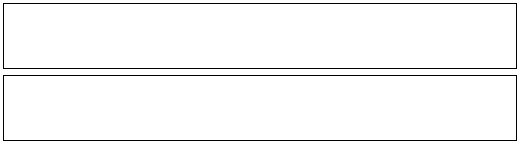

after rgb: torch.cuda.memory_allocated()=786432
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
# |hide
# |eval: false

if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.ones((2,3, 64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(rgb(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()=}")

    del numbers
    gc.collect()
    # torch.cuda.memory.empty_cache()
    # torch.cuda.synchronize()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)